In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df=pd.read_csv('training.csv', sep=',')
input_train = df.values

print df.shape




(7049, 31)


In [8]:
X_train = input_train[:, 30]
y_train = input_train[:, 0:30]

import os.path
if not os.path.isfile("xtrain.npy"):
    print "read data ..."
    templist = []
    for i in range(X_train.shape[0]):
        templist.append([int(s) for s in X_train[i].split()])
    X_train = np.array(templist)
    np.save("xtrain.npy", X_train)
else:
    print "training data xtrain.npy exists. loading... "
    np.load("xtrain.npy")



read data ...


(7049, 9216)
(7049, 30)
(15,) (15,)


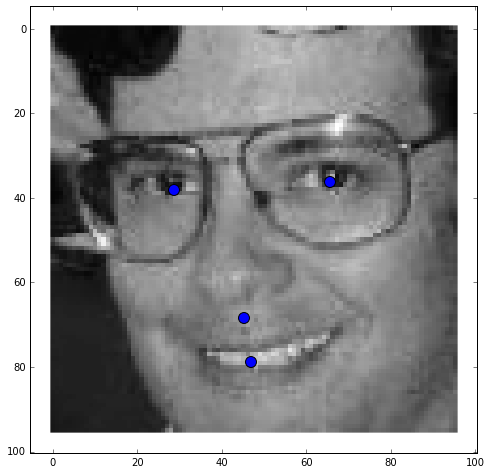

In [9]:
print X_train.shape
print y_train.shape

a = X_train[4096].reshape(96, 96)
b = y_train[4096]
b_x = b[0::2]
b_y = b[1::2]
print b_x.shape, b_y.shape

plt.imshow(a)
plt.scatter(b_x, b_y, s=120)
plt.show()


In [31]:
print y_train[4096]
# y_train = np.stack(y_train)

# print y_train[0:2, :]

# print y_train.shape
# print y_train.dtype
# y_nan_check = np.isnan(y_train[0])

# a = np.sum(y_nan_check, axis=1)
# b = np.sum(y_nan_check, axis=0)

# full_image_check_idx = (a==30)
# print np.sum(full_image_check_idx)
# print b


count = 0
for y in y_train:
    isnan = False
    for yy in y:
        if np.isnan(yy):
            isnan = True
            break
    if isnan:
        count += 1
print count



[65.6130976744 36.202827907 28.762481860500003 38.2312186047 nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan 45.3282976744
 68.3202976744 nan nan nan nan nan nan 47.018790697700005 78.8007069767]
4909


In [45]:

print type(y_train)
print type(y_train[33])
y_train = y_train.astype(float)
print y_train[0].dtype

y_nan_check = np.isnan(y_train)

a = np.sum(y_nan_check, axis=1)
b = np.sum(y_nan_check, axis=0)

full_image_check_idx = (a > 0)
print np.sum(full_image_check_idx)
print b

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
float64
4909
[  10   10   13   13 4778 4778 4782 4782 4781 4781 4781 4781 4779 4779 4824
 4824 4779 4779 4813 4813    0    0 4780 4780 4779 4779 4774 4774   33   33]


In [48]:
labels = "left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image"
print zip(labels.split(",") , b)

[('left_eye_center_x', 10), ('left_eye_center_y', 10), ('right_eye_center_x', 13), ('right_eye_center_y', 13), ('left_eye_inner_corner_x', 4778), ('left_eye_inner_corner_y', 4778), ('left_eye_outer_corner_x', 4782), ('left_eye_outer_corner_y', 4782), ('right_eye_inner_corner_x', 4781), ('right_eye_inner_corner_y', 4781), ('right_eye_outer_corner_x', 4781), ('right_eye_outer_corner_y', 4781), ('left_eyebrow_inner_end_x', 4779), ('left_eyebrow_inner_end_y', 4779), ('left_eyebrow_outer_end_x', 4824), ('left_eyebrow_outer_end_y', 4824), ('right_eyebrow_inner_end_x', 4779), ('right_eyebrow_inner_end_y', 4779), ('right_eyebrow_outer_end_x', 4813), ('right_eyebrow_outer_end_y', 4813), ('nose_tip_x', 0), ('nose_tip_y', 0), ('mouth_left_corner_x', 4780), ('mouth_left_corner_y', 4780), ('mouth_right_corner_x', 4779), ('mouth_right_corner_y', 4779), ('mouth_center_top_lip_x', 4774), ('mouth_center_top_lip_y', 4774), ('mouth_center_bottom_lip_x', 33), ('mouth_center_bottom_lip_y', 33)]
